# Amazon Product Reviews Sentiment Analysis (Week 10 - Final Project)
## Kostis Konstantinos

### Dataset description

The dataset used is the Amazon Product Reviews dataset and it can be downloaded from [Kaggle](https://www.kaggle.com/datasets/jillanisofttech/amazon-product-reviews). The data is a single CSV file. It contains **568454 reviews** of different amazon products and the number of **attributes is 10**. More specifically the fields include: a record id, the id of product being reviewed, the id of the reviewer, the name of the reviewer, the numerator and the denominator for helpfulness of review, the rating/score of the review, a summary of the review and the full review text.
There are no missing values in the dataset.

### Motivation

What i would like to do with the amazon-product-reviews dataset is to investigate the possibility of creating a sentiment analysis classifier for product reviews. Creating sentiment analysis tools is a very interesting problem and it benefits very much e-commerce companies. With such a tool there is no need for humans to waste hours to understand product reviews but simply delegate the task to a tool, so the workforce of the company can put in hours for other important things.

### Research Questions

- What kind of reviews does the dataset contain? Mostly bad? Mostly good?
- Using sampling, how does a word cloud of positive reviews look like?
  - Using sampling, how does a negative reviews word cloud look like? Are there any clear differences from the positives world cloud?
- Is it possible to create a sentiment classifier for reviews with an acceptable, >=80% (on the test set) accuracy?

### Exploring the data

In [1]:
# importing libraries

import string
import re
from collections import Counter

import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/Reviews.csv')

print("Number of rows: {}".format(len(df)))
print("Number of columns: {}".format(len(df.columns)))
print(df.dtypes)

df.head()

Number of rows: 568454
Number of columns: 10
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# value counts for score
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [4]:
# data of interest
df = df[['Text', 'Score']]
print("* Missing values:\n{}".format(df.isnull().any()))
empty_text_reviews = df[df['Text'].str.len() == 0].index
print("* Unique scores: {}".format(df['Score'].unique()))
print("* Reviews with empty text: {}".format(len(empty_text_reviews)))

* Missing values:
Text     False
Score    False
dtype: bool
* Unique scores: [5 1 4 2 3]
* Reviews with empty text: 0


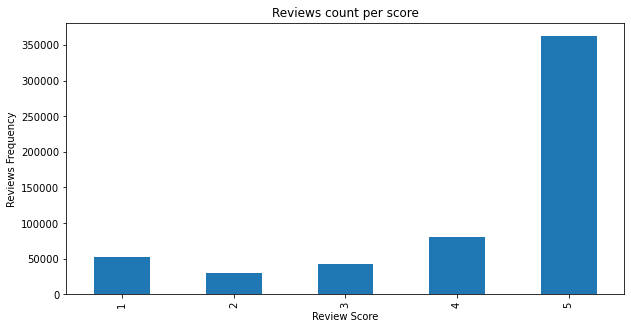

In [5]:
# reviews per score
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Reviews count per score', figsize=(10, 5))
ax.set_xlabel('Review Score')
ax.set_ylabel('Reviews Frequency')
plt.show()

Ok! So most reviews are positive! Good to know.

Intuitively, reviews with score 1 and 2 are negative, reviews with score 3 should be kind of neutral and reviews with score 4 and 5 are positive. So, lets see what kind of words exist in these categories-by-intuition.

Due to the large dataset, sampling will be used in order to not explode in terms of memory.

In [6]:
# sample review texts per rating
review_score_samples = {1: 20000, 2: 20000, 3: 40000, 4: 20000, 5: 20000}

# random state for reproducible results
random_state = 2022

# gather samples into a single data-frame
data_frames = []
for score, samples_len in review_score_samples.items():
    selected_df = df[df['Score'] == score].sample(samples_len, random_state=random_state).copy()
    data_frames.append(selected_df)
    
examined_df = pd.concat(data_frames, axis=0)

# separate the samples per score band
negative_reviews = examined_df[(examined_df['Score'] == 1) | (examined_df['Score'] == 2)]
neutral_reviews = examined_df[examined_df['Score'] == 3]
positive_reviews = examined_df[(examined_df['Score'] == 4) | (examined_df['Score'] == 5)]

In [7]:
# inspect samples visually (feel free to run this a couple of times)
print("Postive: {}".format(positive_reviews['Text'].sample(1).values))
print()
print("Negative: {}".format(negative_reviews['Text'].sample(1).values))
print()
print("Neutral: {}".format(neutral_reviews['Text'].sample(1).values))

Postive: ['I accidentally stumbled upon these Crunchy Dills in my local market and now cannot find them anywhere local.  These are the best German Dills I have ever eaten.  These are the only pickles I can eat out of the jar--no sandwich needed. I highly recommend them to anyone who adores authentic German pickles.']

Negative: ['Product tasted like cardboard.  I knew it was a easy fix for a meal but i was very disappointed with the final product.']

Neutral: ["I read about the benefits of Pau D'Arco tea and decided to give it a try. It's hard to find this tea in the market. The Whole Foods near my house doesn't have it either.<br /><br />The taste of this herbal tea is interesting: it's got a hint of sweetness with a very slight medicinal bitterness. Feels quite dry and alkaline to me. Color is light brown. Not particularly delightful or tasty, neither does it have a strong, captivating aroma like the Japanese roasted green tea - it's just weird beyond description. Reminds me of dried

#### Insights up until now

- **Visual inspection of results above (you may run the cell above multiple times), reveals to me that reviews with score 3, neutral as i called them, are really difficult to handle. They contain both good and bad reviews and inconclusive ones. So i will drop them from the dataset and handle only positive and negative ones.**

- **Review texts contain html tags, so they need to be cleaned**

In [8]:
# cleanup the sample positive and negative review texts
# 1. clean html tags and replace them with ' '
# 2. lowercase all words
# 3. tokenize text to words (whitespace tokenizer)
# 4. remove stop-words and punctuation (and strip remaining punctuation)
# 5. return a list of words
stop_words = set(stopwords.words('english') + list(string.punctuation))
tokenizer = WhitespaceTokenizer()

def clean_text(review_text):
    html_tag=re.compile('<[^>]*>')
    clean_text = re.sub(html_tag, ' ', review_text)
    clean_text = clean_text.lower()
    tokens = [word for word in tokenizer.tokenize(clean_text) if word not in stop_words]
    tokens = [token.strip(string.punctuation) for token in tokens]

    return tokens

negative_reviews['Text'] = negative_reviews['Text'].apply(lambda review_text: clean_text(review_text))
positive_reviews['Text'] = positive_reviews['Text'].apply(lambda review_text: clean_text(review_text))

/var/folders/wm/r9h9b19s7mq1wgqf0gvnsnz80000gn/T/ipykernel_4601/883457218.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['Text'] = negative_reviews['Text'].apply(lambda review_text: clean_text(review_text))
/var/folders/wm/r9h9b19s7mq1wgqf0gvnsnz80000gn/T/ipykernel_4601/883457218.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['Text'] = positive_reviews['Text'].apply(lambda review_text: clean_text(review_text))


In [9]:
# lets see what are the top 50 words per sentiment
top_k = 50

negative_words = [word for words_list in negative_reviews['Text'].to_list() for word in words_list]
positive_words = [word for words_list in positive_reviews['Text'].to_list() for word in words_list]

counter_negatives = Counter(negative_words)
counter_positives = Counter(positive_words)

print("Top {} positive words:\n {}".format(top_k, counter_positives.most_common(top_k)))
print("Top {} negative words:\n {}".format(top_k, counter_negatives.most_common(top_k)))

Top 50 positive words:
 [('like', 19190), ('good', 16965), ('coffee', 12778), ('one', 12692), ('great', 12571), ('taste', 12221), ('flavor', 11428), ('tea', 10521), ('it', 10049), ('product', 9890), ('would', 9019), ('love', 8922), ('food', 8352), ('get', 7784), ('really', 7662), ('little', 7109), ('much', 6684), ('use', 6398), ('also', 6370), ('time', 5963), ('price', 5832), ('well', 5654), ('best', 5496), ("i'm", 5443), ('make', 5391), ('find', 5281), ('tried', 5254), ('better', 5244), ("i've", 5161), ('buy', 5072), ('amazon', 5069), ('even', 4852), ('try', 4820), ('water', 4749), ('eat', 4632), ('dog', 4436), ('first', 4340), ('chocolate', 4254), ('bag', 4224), ('sweet', 4118), ('bit', 4088), ('them', 4075), ('drink', 4026), ('found', 4001), ('sugar', 3983), ('cup', 3960), ('think', 3942), ('nice', 3893), ('used', 3884), ('still', 3713)]
Top 50 negative words:
 [('like', 22194), ('taste', 16012), ('product', 15332), ('one', 13548), ('would', 13284), ('it', 11686), ('coffee', 11405),

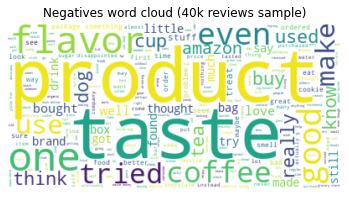

In [17]:
# creating word clouds as visualizations

negatives_text = " ".join(negative_words)
positives_text = " ".join(positive_words)

negative_cloud = WordCloud(max_words=5000, background_color="white").generate(negatives_text)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.title('Negatives word cloud (40k reviews sample)')
plt.axis("off")
plt.show()

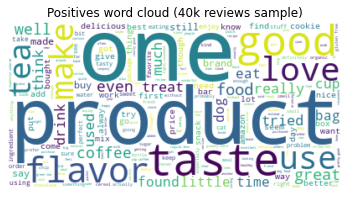

In [18]:
positive_cloud = WordCloud(max_words=5000, background_color="white").generate(positives_text)
plt.imshow(positive_cloud, interpolation='bilinear')
plt.title('Positives word cloud (40k reviews sample)')
plt.axis("off")
plt.show()

So if we look carefully we can see that in the positives word cloud we can find the words: 'best', 'delicious', 'love' which do not seem present in the negatives cloud. Still, words like 'taste', 'good', 'flavor', 'product' and others exist in both, so the word-clouds do not help that much.

### Data preparation & cleaning

The steps of preparing the data include:
- Selecting the appropriate columns (Text, Score)
- Droping all rows where the score is 3
- Processing the reviews text
  1. clean html tags and replace them with ' '
  2. lowercase all words
  3. tokenize text to words (using whitespace tokenizer)
  4. remove stop-words and punctuation
  5. strip remaining punctuation
  6. return a list of tokens
- Creating a new 'Tokens' column as an output of the previous step
- Creating a new column named 'Sentiment'
  - 'positive' is given to reviews with score 4 and 5
  - 'negative' is given to reviews with score 1 and 2
- Balancing the positive reviews number to be equal to the number of negatives
- Shuffle the final dataframe

In [12]:
# A class responsible to pre-process data (as per the steps in the previous cell)
class Preprocessor:
    HTML_TAG_RE = re.compile('<[^>]*>')

    def __init__(self, data_location, random_state=2022):
        self.data_location = data_location
        self.random_state = random_state

        self.stop_words = stopwords.words('english')
        self.punctuation = string.punctuation
        self.blocked_words = set(self.stop_words + list(self.punctuation))
        self.tokenizer = WhitespaceTokenizer()

        self.df = None
        self.processed_df = None

    def preprocess(self):
        self.df = self.read_data()
        self.drop_neutral()
        self.select_columns()
        self.preprocess_reviews()
        self.create_target()
        self.balance_categories()

        columns = ['Tokens', 'Sentiment']
        self.processed_df = self.df[columns].copy()
        
        return self.processed_df.copy()

    def read_data(self):
        return pd.read_csv(self.data_location)
    
    def drop_neutral(self):
        neutral_mask = self.df['Score'] == 3
        self.df = self.df[~neutral_mask]

    def select_columns(self):
        columns = ['Text', 'Score']

        return self.df[columns]

    def preprocess_text(self, review_text):
        clean_text = re.sub(self.HTML_TAG_RE, ' ', review_text)
        clean_text = clean_text.lower()
        tokens = [word for word in self.tokenizer.tokenize(clean_text) if word not in self.blocked_words]
        tokens = [token.strip(string.punctuation) for token in tokens]

        return tokens

    def preprocess_reviews(self):
        self.df['Tokens'] = self.df['Text'].apply(lambda review: self.preprocess_text(review))

    def create_target(self):
        positives_mask = (self.df['Score'] == 4) | (self.df['Score'] == 5)
        negatives_mask = (self.df['Score'] == 1) | (self.df['Score'] == 2)

        self.df['Sentiment'] = np.NAN

        self.df.loc[self.df[positives_mask].index, 'Sentiment'] = 'positive'
        self.df.loc[self.df[negatives_mask].index, 'Sentiment'] = 'negative'
    
    def balance_categories(self):
        negatives = self.df[self.df['Sentiment'] == 'negative']
        positives = self.df[self.df['Sentiment'] == 'positive']

        min_samples = np.minimum(len(negatives), len(positives))

        negatives = negatives.sample(min_samples, random_state=self.random_state)
        positives = positives.sample(min_samples, random_state=self.random_state)
        
        self.df = pd.concat([negatives, positives])

        # shuffle the data-frame
        self.df = self.df.sample(frac=1, random_state=self.random_state)

In [13]:
preprocessor = Preprocessor('data/Reviews.csv')
reviews_df = preprocessor.preprocess()

### Sentiment Classification (and methodology)

The steps are:
 - Perform **train/test split** using 20% for the test size
 - Use the **TF-IDF vectorizer** to transform the word lists into numerical vectors (see below how i tuned the vectorizer)
   - fit and transform on the train set
   - then transform the test set
 - Train a **logistic regression** classifier. Report train and test accuracy score. Create a confusion matrix for the predictions.
 - Train an **SVM** classifier. Report train and test accuracy score. Create a confusion matrix for the predictions.
 - **Compare** the results and find the best one.
 - The above steps were run a couple of times to fine tune the vectorizer. I fixed the max_iter parameter to 200.

(reading: https://scholar.smu.edu/cgi/viewcontent.cgi?article=1051&context=datasciencereview)

#### Tuning the vectorizer for optimal accuracy (the most critical part for feature engineering)

There are many paramters. The ones that will be used are:
- min_df
- max_features
- n_gram_range

Run a few combinations and report on test accuracy. Keep the the combination with the best test accuracy (i am keeping only the first 5 decimal digits)

| Parameters Setup | Logistic Regression Test Accuracy | SVM Test Accuracy |
| ---------------- | --------------------------------- |-------------------|
|min_df=1(default), max_features=None(default), n_gram_range=(1,1)(default) | 0.90254  | 0.89096 |
|min_df=1(default), max_features=10_000, n_gram_range=(3,3) | 0.66838 | 0.66317 |
|min_df=5, max_features=10_000, n_gram_range=(3,3) | 0.66877 | 0.66335 |
|min_df=10, max_features=20_000, n_gram_range=(1,3) | 0.91470 | 0.90211 |
|min_df=10, max_features=None(default), n_gram_range=(1,3) | 0.91942 |0.90464 |

In [14]:
# create a class that applies the methodology written above

class SentimentAnalyzer:
    def __init__(self, data, test_size=0.2, random_state=2022):
        self.data = data
        self.test_size = test_size
        self.random_state = random_state

        self.vectorizer = TfidfVectorizer(
            tokenizer=self.identity, preprocessor=self.identity,
            min_df=10, max_features=None, ngram_range=(1,3))

        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

    def prepare(self):
        self.perform_train_test_split()
        self.vectorize_data()

        train_samples = self.X_train.shape[0]
        test_samples = self.X_test.shape[0]
        
        print("Number of training instances: {}".format(train_samples))
        print("Number of test instances: {}".format(test_samples))

    def perform_train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data['Tokens'], self.data['Sentiment'], 
            test_size=self.test_size, random_state=self.random_state)

    def identity(self, document):
        """An identity function for TfIdfVectorizer

        This is needed since the text is already processed and tokenized.
        """
        return document

    def vectorize_data(self):
        self.X_train = self.vectorizer.fit_transform(self.X_train)
        self.X_test = self.vectorizer.transform(self.X_test)

    def train_and_analyze_classifier(self, classifier):
        classifier.fit(self.X_train, self.y_train)

        classifier_name = classifier.__class__.__name__

        test_predictions = classifier.predict(self.X_test)
        train_predictions = classifier.predict(self.X_train)

        test_accuracy = accuracy_score(y_true=self.y_test.values, y_pred=test_predictions)
        train_accuracy = accuracy_score(y_true=self.y_train.values, y_pred=train_predictions)
        
        df = pd.DataFrame(
            {
                'Test Accuracy': [test_accuracy],
                'Train Accuracy': [train_accuracy]
            },
            index = [classifier_name]
        )

        ConfusionMatrixDisplay.from_predictions(y_true=self.y_test.values, y_pred=test_predictions)

        return df

analyzer = SentimentAnalyzer(reviews_df, test_size=0.2, random_state=2022)
analyzer.prepare()

Number of training instances: 131259
Number of test instances: 32815


,Test Accuracy,Train Accuracy
LogisticRegression,0.919427,0.942922


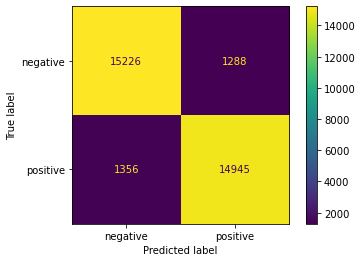

In [15]:
logistic_regression = LogisticRegression(max_iter=200, random_state=2022)
analyzer.train_and_analyze_classifier(logistic_regression)

,Test Accuracy,Train Accuracy
SGDClassifier,0.904647,0.914962


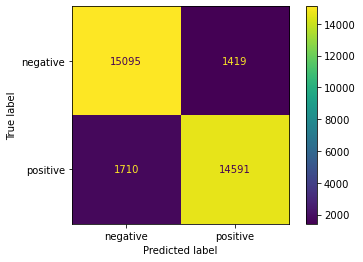

In [16]:
svm = SGDClassifier(loss='hinge', max_iter=200, random_state=2022)
analyzer.train_and_analyze_classifier(svm)